In [1]:
import torch
import torch.nn as nn

import numpy as np

In [2]:
DEBUG = False

## Partial Convolution

In [3]:
class PartialConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding)
        
        self.sum_conv = nn.Conv2d(in_channels, 1, kernel_size, stride=stride, padding=padding, bias=False)
        self.sum_conv.weight.data.fill_(1)
        self.sum_conv.weight.requires_grad_(False)  # TODO: check that not learning
        
    
    def forward(self, x, mask):
        """
        Forward pass of Partial Convolution (arxiv.org/abs/1804.07723)
        
        Parameters
        ----------
        x : FloatTensor, input feature tensor of shape (b, c, h, w)
        mask : FloatTensor, binary mask tensor of shape (b, c, h, w)
        """
        #mask_unsqueezed = mask.unsqueeze(1)  # making mask of shape (b, 1, h, w)
        assert x.shape == mask.shape, 'x and mask shapes must be equal'
        
        x_masked = x * mask
        x_after_conv = self.conv(x_masked)

        mask_norm = self.sum_conv(mask)
        x_after_conv_normed = torch.where(mask_norm != 0, x_after_conv / mask_norm, torch.zeros_like(x_after_conv))

        updated_mask_single = (self.sum_conv(mask) > 0).type(torch.FloatTensor)
        updated_mask = torch.cat([updated_mask_single] * self.out_channels, dim=1)

        if DEBUG:
            print('x')
            print(x)
            print()

            print('mask')
            print(mask)
            print()

            print('x_after_conv')
            print(x_after_conv)
            print()

            print('mask_norm')
            print(mask_norm)
            print()

            print('x_after_conv_normed')
            print(x_after_conv_normed)
            print()

            print('updated_mask')
            print(updated_mask)
            print()
            
        return x_after_conv_normed, updated_mask

Testing:

In [4]:
# b, c, h, w = 2, 2, 5, 5

# x = torch.randint(0, 5, (b, c, h, w))

# mask_single = (torch.rand((b, h, w)) > 0.8).unsqueeze(1).type(torch.FloatTensor)
# print(mask_single.shape)
# mask = torch.cat([mask_single] * c, dim=1)
# print(mask.shape)

# pconv = PartialConv2d(c, 1, 3, stride=2)

# x_new, mask_new = pconv(x, mask)

## Network

In [5]:
class InpaintDownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=2, padding='same', bn=True):
        super().__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        
        padding = (kernel_size - 1) // 2 if padding == 'same' else padding
        self.padding = padding
        
        self.bn = bn
        
        self.pconv = PartialConv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding)
        if bn:
            self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x, mask):
        x, mask = self.pconv(x, mask)
        if self.bn:
            x = self.bn(x)
        x = self.relu(x)
        
        return x, mask

In [6]:
# b, c, h, w = 2, 3, 256, 256

# x = torch.randint(0, 5, (b, c, h, w))

# mask_single = (torch.rand((b, h, w)) > 0.8).unsqueeze(1).type(torch.FloatTensor)
# mask = torch.cat([mask_single] * c, dim=1)

# down_blocks = [
#     InpaintDownBlock(3, 64, 7, stride=2, bn=False),
#     InpaintDownBlock(64, 128, 5, stride=2, bn=True),
#     InpaintDownBlock(128, 256, 5, stride=2, bn=True),
#     InpaintDownBlock(256, 512, 3, stride=2, bn=True),
#     InpaintDownBlock(512, 512, 3, stride=2, bn=True),
#     InpaintDownBlock(512, 512, 3, stride=2, bn=True),
#     InpaintDownBlock(512, 512, 3, stride=2, bn=True),
#     InpaintDownBlock(512, 512, 3, stride=2, bn=True)
# ]

# for down_block in down_blocks:
#     print(x.shape, mask.shape)
#     x, mask = down_block(x, mask)

In [7]:
class InpaintUpBlock(nn.Module):
    def __init__(self, in_channels, in_channels_bridge, out_channels, kernel_size, padding='same', bn=True):
        super().__init__()
        
        self.in_channels = in_channels
        self.in_channels_bridge = in_channels_bridge
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        
        padding = (kernel_size - 1) // 2 if padding == 'same' else padding
        self.padding = padding
        
        self.bn = bn
        
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest', align_corners=True)  # TODO: align corners!
        
        self.pconv = PartialConv2d(in_channels + in_channels_bridge, out_channels, kernel_size, padding=padding)
        if bn:
            self.bn = nn.BatchNorm2d(out_channels)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        
    def forward(self, x, mask, x_bridge, mask_bridge):
        x, mask = self.upsample(x), self.upsample(mask)
        torch.cat([mask, mask_bridge], dim=1)
        x, mask = torch.cat([x, x_bridge], dim=1), torch.cat([mask, mask_bridge], dim=1)
        
        x, mask = self.pconv(x, mask)
        
        if self.bn:
            x = self.bn(x)
        x = self.leaky_relu(x)
        
        return x, mask

In [8]:
# b, c, h, w = 2, 3, 256, 256

# x = torch.randint(0, 5, (b, c, h, w))

# mask_single = (torch.rand((b, h, w)) > 0.8).unsqueeze(1).type(torch.FloatTensor)
# mask = torch.cat([mask_single] * c, dim=1)

# c_bridge = 7
# x_bridge = torch.randint(0, 5, (b, c_bridge, 2 * h, 2 * w))

# mask_single_bridge = (torch.rand((b, 2 * h, 2 * w)) > 0.8).unsqueeze(1).type(torch.FloatTensor)
# mask_bridge = torch.cat([mask_single_bridge] * c_bridge, dim=1)

# up_block = InpaintUpBlock(c, c_bridge, 3, 3, bn=True)

# x_new, mask_new = up_block(x, mask, x_bridge, mask_bridge)

In [9]:
class InpaintNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        self.depth = 8
        
        # down
        self.down_blocks = nn.ModuleList([
            InpaintDownBlock(in_channels, 64, 7, stride=2, padding='same', bn=False),
            InpaintDownBlock(64, 128, 5, stride=2, padding='same', bn=True),
            InpaintDownBlock(128, 256, 5, stride=2, padding='same', bn=True),
            InpaintDownBlock(256, 512, 3, stride=2, padding='same', bn=True),
            InpaintDownBlock(512, 512, 3, stride=2, padding='same', bn=True),
            InpaintDownBlock(512, 512, 3, stride=2, padding='same', bn=True),
            InpaintDownBlock(512, 512, 3, stride=2, padding='same', bn=True),
            InpaintDownBlock(512, 512, 3, stride=2, padding='same', bn=True)
        ])
        
        # up
        self.up_blocks = nn.ModuleList([
            InpaintUpBlock(512, 512, 512, 3, padding='same', bn=True),
            InpaintUpBlock(512, 512, 512, 3, padding='same', bn=True),
            InpaintUpBlock(512, 512, 512, 3, padding='same', bn=True),
            InpaintUpBlock(512, 512, 512, 3, padding='same', bn=True),
            InpaintUpBlock(512, 256, 256, 3, padding='same', bn=True),
            InpaintUpBlock(256, 128, 128, 3, padding='same', bn=True),
            InpaintUpBlock(128, 64, 64, 3, padding='same', bn=True),
            InpaintUpBlock(64, 3, 3, 3, padding='same', bn=False)
        ])
        
#         down_n_filters = [64, 128, 256, 512, 512, 512, 512, 512]
#         down_kernel_sizes = [7, 5, 5, 3, 3, 3, 3, 3]
#         down_use_bn = [False, True, True, True, True, True, True, True]
        
#         for i in range(self.depth):
#             down_block = InpaintDownBlock(in_channels, down_n_filters[i], down_kernel_sizes[i],
#                                           stride=2, padding='same', bn=down_use_bn[i])
#             down_blocks.append(down_block)
#             in_channels = down_n_filters[i]

        
#         # up
#         up_blocks = []
#         up_n_filters = [512, 512, 512, 512, 256, 128, 64]
#         up_kernel_sizes = [3, 3, 3, 3, 3, 3, 3]
#         up_use_bn = [True, True, True, True, True, True, True]
#         for i in range(self.depth - 1):
#             in_channels_bridge = down_n_filters[len(down_blocks) - i - 2]
#             up_block = InpaintUpBlock(in_channels, in_channels_bridge, up_n_filters[i], up_kernel_sizes[i],
#                                       padding='same', bn=up_use_bn[i])
#             up_blocks.append(up_block)
#             in_channels = up_n_filters[i]
        
#         up_block = InpaintUpBlock(in_channels, self.in_channels, out_channels, 3,
#                                   padding='same', bn=False)    
#         up_blocks.append(up_block)
        
#         # final
#         self.down_blocks = nn.ModuleList(down_blocks)
#         self.up_blocks = nn.ModuleList(up_blocks)
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, mask):
        x_bridges, mask_bridges = [], []
        for i in range(self.depth):
            x_bridges.append(x)
            mask_bridges.append(mask)
            x, mask = self.down_blocks[i](x, mask)

        for i in range(self.depth):
            x, mask = self.up_blocks[i](x, mask, x_bridges[-i - 1], mask_bridges[-i - 1])
        
        x = self.sigmoid(x)
        return x, mask

In [10]:
# b, c, h, w = 2, 3, 256, 256

# x = torch.randint(0, 5, (b, c, h, w))

# mask_single = (torch.rand((b, h, w)) > 0.95).unsqueeze(1).type(torch.FloatTensor)
# # print(mask_single.shape)
# mask = torch.cat([mask_single] * c, dim=1)
# # print(mask.shape)

# inpaint_net = InpaintNet(3, 3)

# x_new, mask_new = inpaint_net(x, mask)

---

## Imports

In [11]:
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from matplotlib import pylab as plt
%matplotlib inline

In [12]:
from imp import reload
import inpaint
reload(inpaint)

<module 'inpaint' from '/playground/inpaint/inpaint/__init__.py'>

## Setup

In [13]:
class config:
    device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
    
    train_dataset_path = './data/celebA-HQ/train'
    val_dataset_path = './data/celebA-HQ/train'
    
    train_batch_size = 4
    val_batch_size = 4
    
    n_epochs = 2
    
    n_workers = 1

## Data

In [14]:
train_dataloader = inpaint.make_dataloader(config.train_dataset_path,
                                           batch_size=config.train_batch_size,
                                           shuffle=True,
                                           num_workers=config.n_workers)

val_dataloader = inpaint.make_dataloader(config.val_dataset_path,
                                         batch_size=config.val_batch_size,
                                         shuffle=False,
                                         num_workers=config.n_workers)

Check:

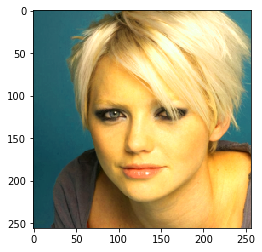

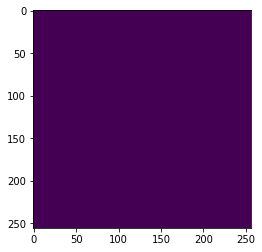

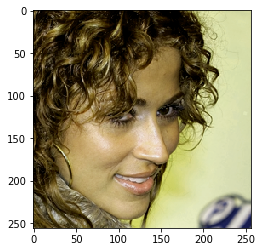

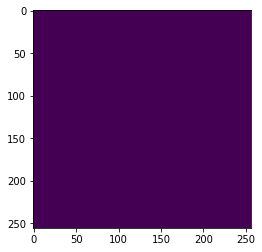

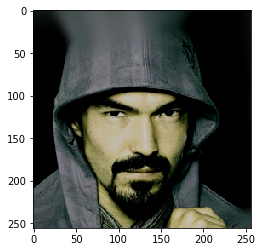

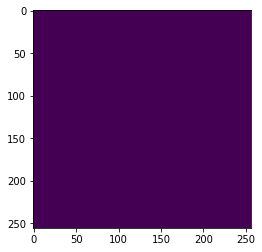

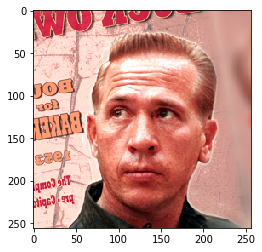

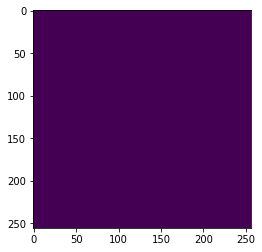

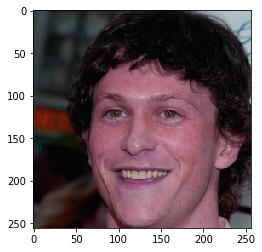

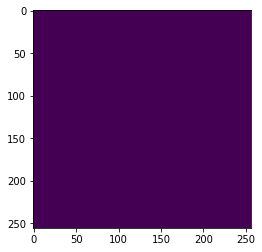

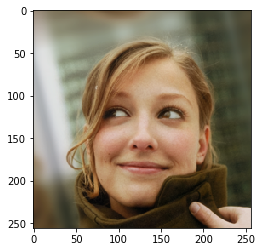

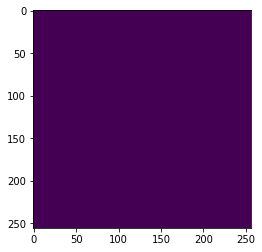

In [15]:
i = 0
for batch in train_dataloader:
    image_batch, mask_batch = batch
    plt.imshow(image_batch[0].numpy().transpose((1, 2, 0)))
    plt.show()
    plt.imshow(mask_batch[0].numpy())
    plt.show()
    
    i += 1
    if i > 5: break

## Load model and associated stuff

In [16]:
model = InpaintNet(in_channels=3, out_channels=3)
opt = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))


In [22]:
criterion = inpaint.modules.InpaintLoss()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth


URLError: <urlopen error [Errno -3] Temporary failure in name resolution>

In [28]:
!cd /root/.torch

In [21]:
https://download.pytorch.org/models/vgg16-397923af.pth

SyntaxError: invalid syntax (<ipython-input-21-eb71f701b95b>, line 1)

In [29]:
import torchvision as tv

In [30]:
_VGG = tv.models.vgg16(True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth


URLError: <urlopen error [Errno -3] Temporary failure in name resolution>

## Train loop

In [ ]:
for epoch in range(config.n_epochs):
    for batch in train_dataloader:
        image_batch, mask_batch = batch
        

In [ ]:
mask_batch.shape